<h5>Computer Science and Engneering<h5>
<img src='assets/ai.png' width=500px>
<h1> A Project By Indronil Mondal <h1>
<h2> on Artificial Intelligence <h2>

# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
import torch
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, transforms, models
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import OrderedDict
from PIL import Image
import json

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/master/torchvision/transforms.html#)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. This converts the values of each color channel to be between -1 and 1 instead of 0 and 1.

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
    
#Define data transforms
data_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize(norm_mean,
                                                             norm_std)])
#Define training data transforms
data_trans_train = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomRotation(30),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(norm_mean,
                                                          norm_std)])
#Load the datasets
train_dataset = datasets.ImageFolder(train_dir, transform=data_trans_train)
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=data_transforms)
    
#Define dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32)
    
class_idx = train_dataset.class_to_idx

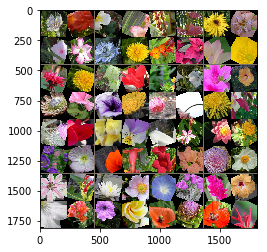

In [11]:
#View our data

def dtshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([norm_mean])
    std = np.array([norm_std])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
dataiter = iter(trainloader)
images, labels = dataiter.next()



# Make a grid from batch
dtshow(torchvision.utils.make_grid(images))




### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [12]:


with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [5]:
# TODO: Build and train your network
dropout=0.5
learningRate = 1.0
    
model = models.alexnet(pretrained=True)

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(9216, 4096)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(4096, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))    
   
for param in model.parameters():
    param.requires_grad = False
        
    
        
model.classifier = classifier
criterion = nn.NLLLoss()
optimizer = optim.Adadelta(model.classifier.parameters(), learningRate )
model.cuda()


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (fc1): Linear(in_features=9216, out_features=4096, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=4096, out_features=102, bias=True)
    (output): LogSoftmax()
  )

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [6]:
# TODO: Do validation on the test set
epochs = 15
print_every = 5
steps = 0
loss_show=[]


for epoch in range(epochs):
    
    running_loss = 0
    for batch, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs,labels = inputs.to('cuda'), labels.to('cuda')
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()
            loss = 0
            accuracy=0
            
            
            for batch, (inputs2,labels2) in enumerate(validloader):
                optimizer.zero_grad()
                
                inputs2, labels2 = inputs2.to('cuda:0') , labels2.to('cuda:0')
                model.to('cuda:0')
                with torch.no_grad():    
                    outputs = model.forward(inputs2)
                    loss = criterion(outputs,labels2)
                    ps = torch.exp(outputs).data
                    equality = (labels2.data == ps.max(1)[1])
                    accuracy += equality.type_as(torch.FloatTensor()).mean()
                    
            loss = loss / len(validloader)
            accuracy = accuracy /len(validloader)
            
                    
            
            print("Epoch: {}/{}... ".format(epoch+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every),
                  "Validation Lost {:.4f}".format(loss),
                   "Accuracy: {:.4f}".format(accuracy))
            
            
            running_loss = 0
            



Epoch: 1/15...  Loss: 27.8181 Validation Lost 0.8689 Accuracy: 0.0204
Epoch: 1/15...  Loss: 8.2335 Validation Lost 0.1845 Accuracy: 0.1334
Epoch: 1/15...  Loss: 4.5838 Validation Lost 0.1990 Accuracy: 0.1166
Epoch: 1/15...  Loss: 4.3739 Validation Lost 0.1664 Accuracy: 0.1298
Epoch: 1/15...  Loss: 3.9285 Validation Lost 0.1591 Accuracy: 0.1466
Epoch: 1/15...  Loss: 3.7220 Validation Lost 0.1245 Accuracy: 0.2137
Epoch: 1/15...  Loss: 3.4766 Validation Lost 0.1735 Accuracy: 0.2296
Epoch: 1/15...  Loss: 3.5531 Validation Lost 0.1697 Accuracy: 0.2825
Epoch: 1/15...  Loss: 3.1162 Validation Lost 0.1734 Accuracy: 0.2716
Epoch: 1/15...  Loss: 3.0674 Validation Lost 0.0777 Accuracy: 0.3781
Epoch: 1/15...  Loss: 2.9070 Validation Lost 0.1011 Accuracy: 0.3141
Epoch: 1/15...  Loss: 2.8296 Validation Lost 0.0817 Accuracy: 0.3726
Epoch: 1/15...  Loss: 3.0460 Validation Lost 0.1443 Accuracy: 0.3798
Epoch: 1/15...  Loss: 2.6674 Validation Lost 0.0982 Accuracy: 0.4589
Epoch: 1/15...  Loss: 2.5547 Vali

Epoch: 6/15...  Loss: 1.1181 Validation Lost 0.0304 Accuracy: 0.8054
Epoch: 6/15...  Loss: 1.2204 Validation Lost 0.0123 Accuracy: 0.8166
Epoch: 6/15...  Loss: 1.3027 Validation Lost 0.0101 Accuracy: 0.8046
Epoch: 6/15...  Loss: 1.2487 Validation Lost 0.0394 Accuracy: 0.7913
Epoch: 7/15...  Loss: 0.5199 Validation Lost 0.0431 Accuracy: 0.7812
Epoch: 7/15...  Loss: 1.2143 Validation Lost 0.0223 Accuracy: 0.8106
Epoch: 7/15...  Loss: 1.1506 Validation Lost 0.0246 Accuracy: 0.7819
Epoch: 7/15...  Loss: 0.9814 Validation Lost 0.0223 Accuracy: 0.8193
Epoch: 7/15...  Loss: 1.1562 Validation Lost 0.0225 Accuracy: 0.8133
Epoch: 7/15...  Loss: 1.3891 Validation Lost 0.0233 Accuracy: 0.7989
Epoch: 7/15...  Loss: 0.9718 Validation Lost 0.0313 Accuracy: 0.8172
Epoch: 7/15...  Loss: 1.0801 Validation Lost 0.0180 Accuracy: 0.7926
Epoch: 7/15...  Loss: 1.1929 Validation Lost 0.0763 Accuracy: 0.7808
Epoch: 7/15...  Loss: 1.4810 Validation Lost 0.0333 Accuracy: 0.8003
Epoch: 7/15...  Loss: 1.0565 Valid

Epoch: 12/15...  Loss: 1.1174 Validation Lost 0.0096 Accuracy: 0.8361
Epoch: 12/15...  Loss: 1.1338 Validation Lost 0.0200 Accuracy: 0.8421
Epoch: 12/15...  Loss: 1.0569 Validation Lost 0.0048 Accuracy: 0.8455
Epoch: 12/15...  Loss: 1.0325 Validation Lost 0.0138 Accuracy: 0.8277
Epoch: 12/15...  Loss: 0.8493 Validation Lost 0.0123 Accuracy: 0.8368
Epoch: 12/15...  Loss: 1.1768 Validation Lost 0.0043 Accuracy: 0.8320
Epoch: 12/15...  Loss: 1.2041 Validation Lost 0.0087 Accuracy: 0.8428
Epoch: 12/15...  Loss: 0.9939 Validation Lost 0.0153 Accuracy: 0.8352
Epoch: 12/15...  Loss: 0.9834 Validation Lost 0.0166 Accuracy: 0.8331
Epoch: 12/15...  Loss: 1.1911 Validation Lost 0.0119 Accuracy: 0.8253
Epoch: 13/15...  Loss: 0.8600 Validation Lost 0.0115 Accuracy: 0.8467
Epoch: 13/15...  Loss: 0.9014 Validation Lost 0.0177 Accuracy: 0.8340
Epoch: 13/15...  Loss: 1.0770 Validation Lost 0.0132 Accuracy: 0.8323
Epoch: 13/15...  Loss: 1.0484 Validation Lost 0.0096 Accuracy: 0.8166
Epoch: 13/15...  Los

In [8]:
def checkAccuracy(testloader):    
    correct = 0
    total = 0
    model.to('cuda:0')
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    a=(100 * correct / total)

    print('Accuracy of the network is: {0:.2f} % ' .format(a))
    
    
checkAccuracy(testloader)



Accuracy of the network is: 80.95 % 


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [9]:
# TODO: Save the checkpoint 

model.class_to_idx = train_dataset.class_to_idx
model.cpu()
torch.save({'state_dict':model.state_dict(),
            'class_to_idx':model.class_to_idx}, 'check1.pth')
    
    
    
    

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [5]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def welcomeBack(filepath):
    checkpoint = torch.load(filepath)
    model = models.alexnet()
        
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(9216, 4096)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(4096, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    model.classifier = classifier
    model.load_state_dict(checkpoint['state_dict'])
    
    
    return model, checkpoint['class_to_idx']
model,class_to_idx = welcomeBack('check1.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

In [6]:
model.class_to_idx = train_dataset.class_to_idx
welcomeBack('check1.pth')
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (fc1): Linear(in_features=9216, out_features=4096, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=4096, out_features=102, bias=True)
    (output): LogSoftmax()
  )

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [7]:
image_path =("check.jpg")
image = Image.open(image_path)
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    
    adjustments = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=norm_mean, std=norm_std)
    ])
    pilImg = adjustments(image)
    
    
    return pilImg
    
process_image(image)

tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         ...,
         [ 0.5022,  0.4851,  0.4679,  ...,  0.6392,  0.6734,  0.6734],
         [ 0.5022,  0.5022,  0.4851,  ...,  0.6734,  0.6734,  0.6734],
         [ 0.5022,  0.4851,  0.4851,  ...,  0.6734,  0.6734,  0.6906]],

        [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         ...,
         [ 1.3081,  1.2731,  1.2381,  ...,  1.4482,  1.4482,  1.4482],
         [ 1.3081,  1.2731,  1.2556,  ...,  1.4482,  1.4482,  1.4482],
         [ 1.3081,  1.2906,  1.2731,  ...,  1.4482,  1.4482,  1.4657]],

        [[ 2.6400,  2.6400,  2.6400,  ...,  2.6400,  2.6400,  2.6400],
         [ 2.6400,  2.6400,  2.6400,  ...,  2

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

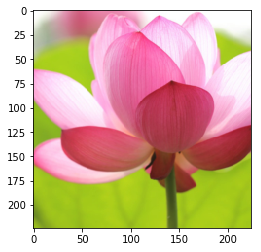

In [8]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image=image.numpy().transpose((1,2,0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

imshow(process_image(image))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [9]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.eval()
    model.to('cuda:0')
    tensor = process_image(image)
    np_array = process_image(image)
    var_inputs = Variable(tensor.float().cuda(), volatile=False)
    var_inputs = var_inputs.unsqueeze(0)
    output = model.forward(var_inputs)  
    ps = torch.exp(output).data.topk(topk)
    probabilities = ps[0].cpu()
    classes = ps[1].cpu()
    class_to_idx_inverted = {model.class_to_idx[k]: k for k in model.class_to_idx}
    mapped_classes = list()
    for label in classes.numpy()[0]:
        mapped_classes.append(class_to_idx_inverted[label])
    return probabilities.numpy()[0], mapped_classes


probabilities, classes = predict(image_path, model)

print("The probabilities Are")
print(probabilities)
print("The Classes Are")
print(classes)

The probabilities Are
[9.9984932e-01 1.4775488e-04 1.5651829e-06 1.0888248e-06 6.0894683e-07]
The Classes Are
['78', '88', '39', '74', '73']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

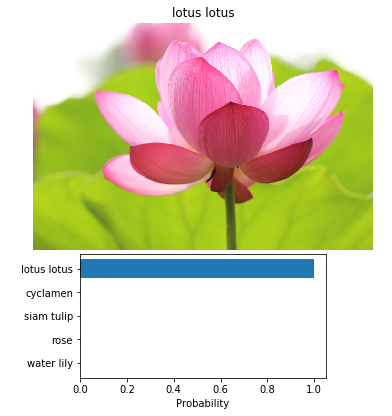

In [10]:
# TODO: Display an image along with the top 5 classes

max_index = np.argmax(probabilities)
max_probability = probabilities[max_index]
label = classes[max_index]

fig = plt.figure(figsize=(9,7))
ax1 = plt.subplot2grid((15,9), (0,0), colspan=9, rowspan=9)
ax2 = plt.subplot2grid((15,8), (9,2), colspan=4, rowspan=5)

image = Image.open(image_path)
ax1.axis('off')
ax1.set_title(cat_to_name[label])
ax1.imshow(image)
labels = []
for cl in classes:
    labels.append(cat_to_name[cl])
y_pos = np.arange(5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(labels)
ax2.invert_yaxis()  
ax2.set_xlabel('Probability')
ax2.barh(y_pos, probabilities, xerr=0, align='center')

plt.show()